Datos cargados correctamente. Dimensiones: (717, 66)
Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.4s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=1; total time=   0.3s
[CV] END .............................estimator__max_depth=2; total time= 

[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=11; total time=   0.5s
[CV] END ............................estimator__max_depth=12; total time=   0.5s
[CV] END ............................estimator__max_depth=12; total time=   0.5s
[CV] END ...................

2024-05-10 20:45:30,807 - INFO - Best mean cross-validation score: 0.377
2024-05-10 20:45:30,807 - INFO - Best parameters: {'estimator__max_depth': 5}
2024-05-10 20:45:30,828 - INFO - Test Accuracy: 0.453
2024-05-10 20:45:30,859 - INFO - Train: 0.746
2024-05-10 20:45:30,859 - INFO - Test: 0.453


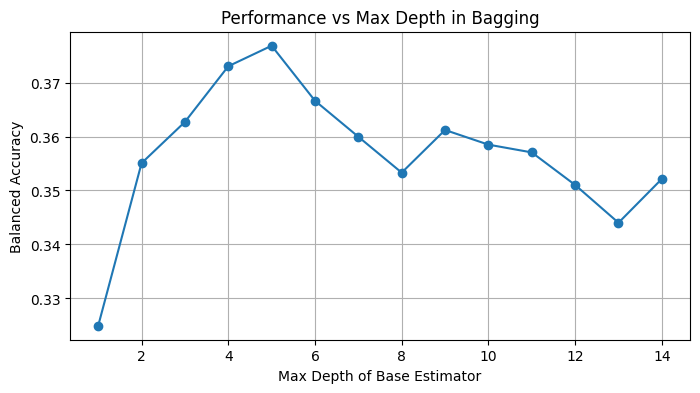

2024-05-10 20:45:30,914 - INFO - Model saved to ../src/models/classifier_models/bagging_model.pkl


In [7]:
# Importaciones esenciales
import logging
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Importación de módulos personalizados
import sys
sys.path.append('../src/production')
from model_classifier import load_and_preprocess_data

# Configuración del logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def main():
    df = load_and_preprocess_data('../data/processed/prediction_dataset_complete.csv')
    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = split_data(X, y)
    y_train_encoded, y_test_encoded = encode_labels(y_train, y_test)
    best_model = train_and_optimize_model(X_train, y_train, X_test, y_test)
    save_model(best_model, 'bagging_model.pkl', '../src/models/classifier_models')

def prepare_data(df):
    X = df.drop('articulacion', axis=1)  # Eliminar la columna objetivo del conjunto de características
    y = df['articulacion']               # Definir el conjunto objetivo
    return X, y

def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def encode_labels(y_train, y_test):
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    return y_train_encoded, y_test_encoded

def train_and_optimize_model(X_train, y_train, X_test, y_test):
    columns = ['total force rate_walk', 'pace_walk', 'step rate_walk', 'thomas tfl', 'genu valgo',
               'pronation excursion (mp->to)_walk', 'thomas psoas', 'impact gs_walk', 'tfi', 'contact ratio_walk',
               'stride length_walk', 'edad', 'index minus','arco aplanado', 'stance excursion (fs->mp)_walk']

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    bagging_model = BaggingClassifier(estimator=rf_classifier, n_estimators=10, random_state=42)
    param_grid_bagging = {'estimator__max_depth': range(1, 15)}
    grid_bagging = GridSearchCV(bagging_model, param_grid=param_grid_bagging, scoring='balanced_accuracy', cv=10, verbose=2)
    grid_bagging.fit(X_train[columns], y_train)

    logging.info("Best mean cross-validation score: {:.3f}".format(grid_bagging.best_score_))
    logging.info("Best parameters: {}".format(grid_bagging.best_params_))

    evaluate_and_plot_model(grid_bagging, X_train, y_train, X_test, y_test, columns)
    return grid_bagging.best_estimator_

def evaluate_and_plot_model(grid_bagging, X_train, y_train, X_test, y_test, columns):
    test_accuracy = grid_bagging.score(X_test[columns], y_test)
    logging.info(f"Test Accuracy: {test_accuracy:.3f}")
    logging.info("Train: {:.3f}".format(grid_bagging.score(X_train[columns], y_train)))
    logging.info("Test: {:.3f}".format(test_accuracy))

    scores = grid_bagging.cv_results_['mean_test_score']
    max_depths = range(1, 15)
    plt.figure(figsize=(8, 4))
    plt.plot(max_depths, scores, '-o')
    plt.xlabel('Max Depth of Base Estimator')
    plt.ylabel('Balanced Accuracy')
    plt.title('Performance vs Max Depth in Bagging')
    plt.grid(True)
    plt.show()

def save_model(model, filename, model_dir):
    """Guarda el modelo entrenado en la ubicación especificada."""
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = os.path.join(model_dir, filename)
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)
    logging.info(f"Model saved to {model_path}")

if __name__ == '__main__':
    main()